# Karaciğer Segmentasyonu Projesi: Lightweight DeepLabV3+ Kullanımı

Bu proje, karaciğer segmentasyonu işlemlerini gerçekleştirmek için **DeepLabV3+ MobilNetV3 Large** modelini kullanır. Aşağıda, projenin şu ana kadar tamamlanmış kısımlarına ilişkin açıklamalar verilmiştir.

---

## Giriş
Bu çalışmada, tıbbi görüntülerde karaciğer segmentasyonu için derin öğrenme modelleri kullanılmaktadır. Model, **DeepLabV3+** mimarisinin hafif bir versiyonu olan **MobilNetV3 Large** üzerine inşa edilmiştir. Girdi görüntüleri ve etiketler, özel bir veri seti sınıfı ile işlenmiş ve model için uygun formatta hazırlanmıştır.

---

## Kullanılan Model: DeepLabV3+ MobilNetV3 Large
- **Önceden Eğitilmiş Model**: Model, önceden eğitilmiş ağırlıklarla başlatılmıştır.
- **Özelleştirilmiş Çıkış Katmanı**: Model, karaciğer segmentasyonu için tek bir çıktı sınıfına uyarlanmıştır.
- **Cihaz Desteği**: Model, mevcut donanıma (GPU veya CPU) göre otomatik olarak çalıştırılmıştır.

Kodun bu bölümünde, model mimarisi aşağıdaki gibi hazırlanmıştır:
1. **DeepLabV3+ MobilNetV3 Large** modeli, önceden eğitilmiş ağırlıklarla yüklenmiştir.
2. Çıkış katmanı, karaciğer segmentasyonu için özelleştirilmiştir.
3. Model, `cuda` destekliyse GPU'da, aksi halde CPU'da çalışacak şekilde yapılandırılmıştır.

---

## Veri Seti ve İşleme
### SpineDataset Sınıfı
Kodda, veri seti aşağıdaki özelliklere sahip bir sınıf ile işlenmiştir:
1. **Veri Yükleme**: Görüntü ve etiket dosyaları belirtilen dizinlerden alınır.
2. **Dönüşüm ve Ön İşleme**: Görüntüler ve etiketler, gerekli dönüşüm fonksiyonlarıyla modele uygun hale getirilmiştir.
3. **Dinamik Boyutlandırma**: Farklı boyutlardaki görüntüler, eğitim sürecine uygun hale getirilmiştir.

Ayrıca, dinamik padding için bir `collate_fn` fonksiyonu tanımlanmıştır. Bu, mini-batch içindeki görüntü ve etiketlerin aynı boyuta getirilmesini sağlar.

---

## Eğitim Süreci
### Model Eğitimi
Eğitim sürecinde:
- **Kayıp Fonksiyonu**: `BCEWithLogitsLoss` seçilmiştir. Bu fonksiyon, ikili sınıflandırma görevlerinde yaygın olarak kullanılır.
- **Optimizasyon**: `Adam` optimizasyon algoritması ile model ağırlıkları güncellenmiştir.
- **Epoch Döngüsü**: Model, belirli bir epoch boyunca eğitilmiş ve her epoch sonunda ortalama kayıp raporlanmıştır.

Eğitim sürecindeki kayıplar, her bir batch için hesaplanmış ve optimizasyon işlemi gerçekleştirilmiştir. Eğitim ilerledikçe modelin doğruluğu artırılmaya çalışılmıştır.

---

## Devam Ediyor...
Sonuçlar ve çıktıların detayları, eğitim tamamlandıktan sonra eklenecektir. Ayrıca modelin doğruluğu, kayıplar ve örnek çıktı segmentasyon görselleri de bu dokümana eklenecektir.

In [2]:
import os
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large  # Daha hafif model
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Cihaz kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Daha hafif DeepLabV3+ Modelini yükle
model = deeplabv3_mobilenet_v3_large(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)

# Veri seti sınıfı
class SpineDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):  # __init__ düzeltilmeli
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.transform = transform

    def __len__(self):  # __len__ düzeltilmeli
        return len(self.image_files)

    def __getitem__(self, idx):  # __getitem__ düzeltilmeli
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("L")
        if self.transform:
            image, label = self.transform(image, label)
        return image, label



# Dönüşüm fonksiyonu
def preprocess_image(image, label):
    image = TF.to_tensor(image).float()
    label = TF.to_tensor(label).float()
    return image, label

# Dinamik padding için collate_fn
def collate_fn(batch):
    images, labels = zip(*batch)
    max_height = max(img.size(1) for img in images)
    max_width = max(img.size(2) for img in images)
    padded_images = [TF.pad(img, (0, 0, max_width - img.size(2), max_height - img.size(1))) for img in images]
    padded_labels = [TF.pad(lbl, (0, 0, max_width - lbl.size(2), max_height - lbl.size(1))) for lbl in labels]
    return torch.stack(padded_images), torch.stack(padded_labels)

# Klasör yolları
image_dir = "./DB/images"
label_dir = "./DB/labels"

# Dataset ve DataLoader
train_dataset = SpineDataset(image_dir, label_dir, transform=preprocess_image)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Eğitim döngüsü
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)['out']
        labels = nn.functional.interpolate(labels, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

# Modeli FP16 olarak kaydet
model.half()
torch.save(model.state_dict(), "deeplabv3_model_fp16.pth")
print("Model başarıyla kaydedildi!")

/home/neoni/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/neoni/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Loss: 0.21631264835596084
Epoch 2/30, Loss: 0.058730522096157076
Epoch 3/30, Loss: 0.038304254934191706
Epoch 4/30, Loss: 0.029460677579045295
Epoch 5/30, Loss: 0.02565245985984802
Epoch 6/30, Loss: 0.023284670785069465
Epoch 7/30, Loss: 0.021227264516055583
Epoch 8/30, Loss: 0.01959475554525852
Epoch 9/30, Loss: 0.01738213747739792
Epoch 10/30, Loss: 0.015925980806350708
Epoch 11/30, Loss: 0.014803415462374687
Epoch 12/30, Loss: 0.01420187797397375
Epoch 13/30, Loss: 0.014873075895011426
Epoch 14/30, Loss: 0.014515689685940742
Epoch 15/30, Loss: 0.013034155741333962
Epoch 16/30, Loss: 0.012140831276774407
Epoch 17/30, Loss: 0.011700774617493153
Epoch 18/30, Loss: 0.010771483015269041
Epoch 19/30, Loss: 0.010462315157055854
Epoch 20/30, Loss: 0.009819806478917599
Epoch 21/30, Loss: 0.009248150624334811
Epoch 22/30, Loss: 0.009110106341540813
Epoch 23/30, Loss: 0.008858048040419817
Epoch 24/30, Loss: 0.008937800861895084
Epoch 25/30, Loss: 0.009083257354795933
Epoch 26/30, L

# Model Testi ve Görselleştirme

Bu bölümde, eğitilen model test veri seti üzerinde değerlendirilmiştir. Tahmin edilen sonuçlar, gerçek etiketlerle karşılaştırılarak görselleştirilmiştir.

## Test Süreci

- **Modelin Eval Modu**: Test sırasında dropout ve batch normalization işlemleri devre dışı bırakılmıştır.
- **Sigmoid Fonksiyonu**: Model çıktıları, 0-1 aralığına çekilmiş ve 0.5 eşik değeri ile ikili maske formatına dönüştürülmüştür.
- **Görselleştirme**: Giriş görüntüsü, gerçek etiket ve model tahmini yan yana gösterilmiştir.

## Test Verisinin Hazırlanması

Test verisi, önceden tanımlanan `SpineDataset` sınıfı ile yüklenmiş ve modele uygun hale getirilmiştir:

```python
test_dataset = SpineDataset(image_dir, label_dir, transform=preprocess_image)

Model başarıyla yüklendi!


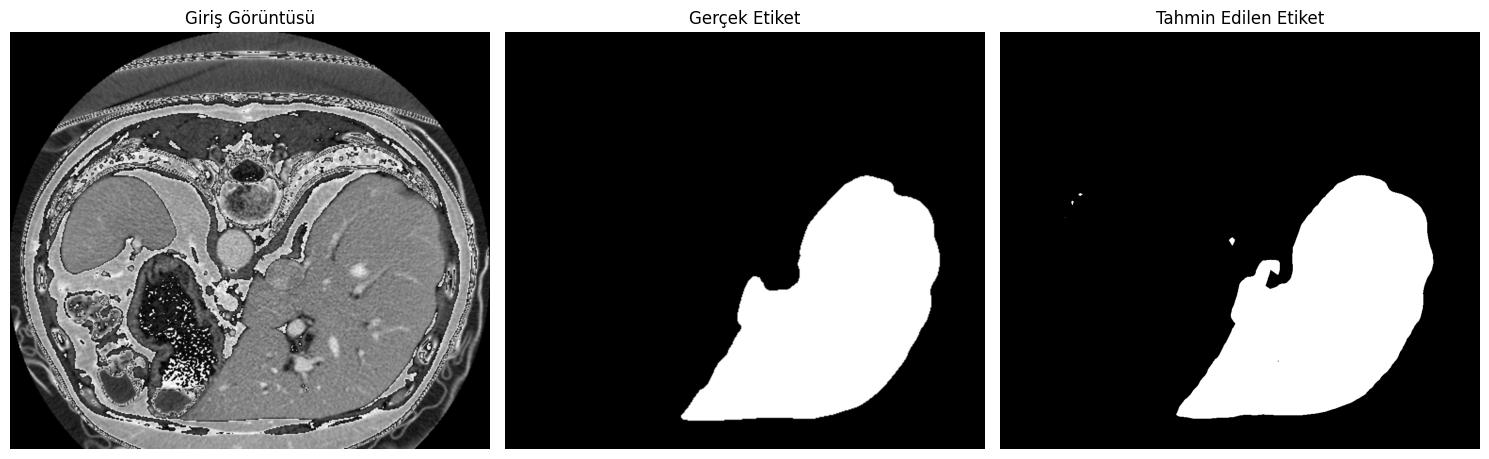

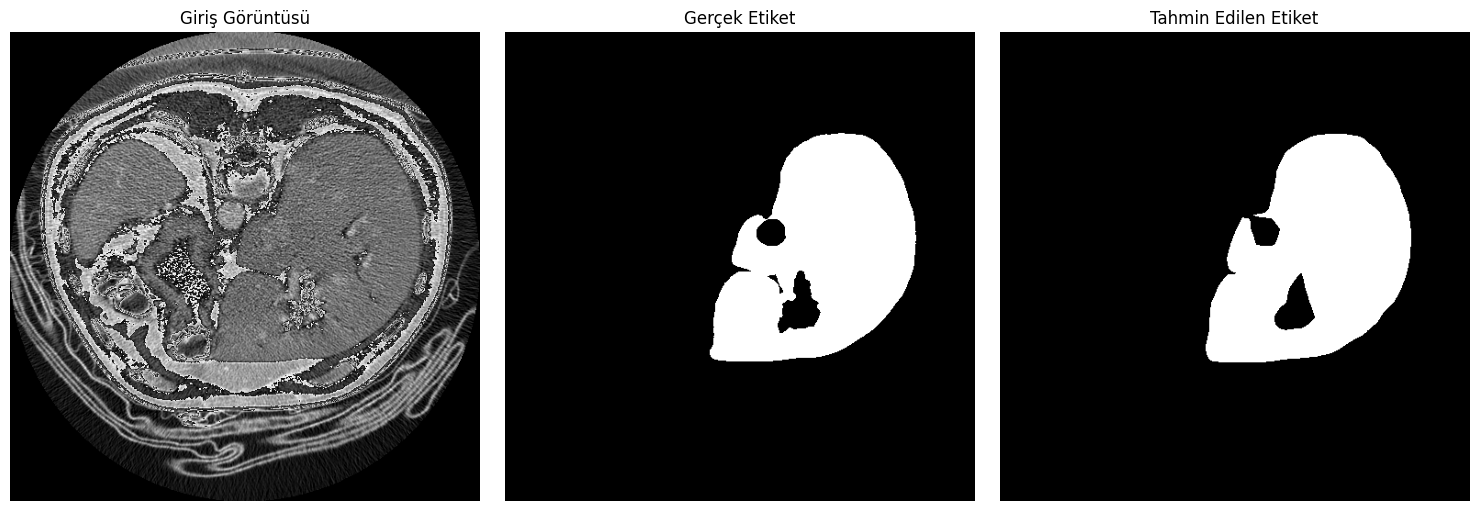

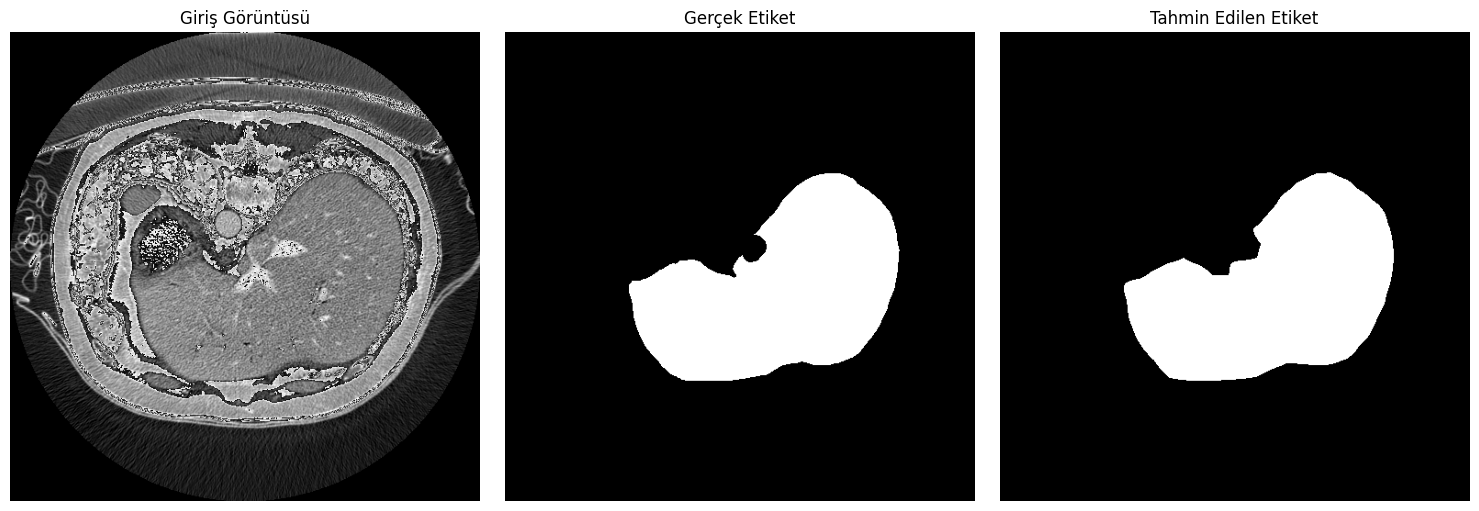

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import torch
# Test fonksiyonu
def test_model(model, test_dataset, num_samples=3):
    model.eval()  # Modeli eval moduna al
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():  # Gradyan hesaplamayı kapat
        for i, (image, label) in enumerate(test_loader):
            if i >= num_samples:  # Eğer num_samples sınırına ulaşıldıysa döngüyü kır
                break

            # Veriyi cihaza taşı
            image = image.to(device).half()  # FP16 formatına geçiş

            # Modelden çıktı al
            output = model(image)['out']
            output = torch.sigmoid(output).squeeze().cpu().numpy()  # Çıkışı sıkıştır ve CPU'ya taşı

            # Çıkışı ikili maske haline getir
            output_binary = (output > 0.5).astype(float)

            # Gerçek etiketi numpy formatına çevir
            label = label.squeeze().numpy()

            # Görüntü, gerçek maske ve tahmin edilen maskeyi yan yana göster
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(TF.to_pil_image(image.cpu().squeeze()), cmap='gray')
            axes[0].set_title("Giriş Görüntüsü")
            axes[0].axis("off")

            axes[1].imshow(label, cmap='gray')
            axes[1].set_title("Gerçek Etiket")
            axes[1].axis("off")

            axes[2].imshow(output_binary, cmap='gray')
            axes[2].set_title("Tahmin Edilen Etiket")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

# Test için SpineDataset oluştur
test_dataset = SpineDataset(image_dir, label_dir, transform=preprocess_image)

# Modeli yükle (FP16 formatı)
model.load_state_dict(torch.load("deeplabv3_model_fp16.pth", map_location=device))
model.half()  # Modeli FP16 formatına geçir
print("Model başarıyla yüklendi!")

# Sadece 3 görüntü üzerinde test et ve görüntüle
test_model(model, test_dataset, num_samples=3)


# Model Performans Değerlendirmesi: IoU Hesaplama

Bu bölümde, modelin test veri seti üzerindeki performansı **Intersection over Union (IoU)** metriği ile değerlendirilmiştir. IoU, modelin tahmin ettiği maskeler ile gerçek etiketler arasındaki örtüşmeyi ölçmek için kullanılır.

---

## IoU Hesaplama Fonksiyonu

- **IoU (Intersection over Union)**:
  - Kesişim ve birleşim bölgesi oranı ile hesaplanır.
  - `IoU = Kesişim / (Birleşim + 1e-6)`
  - **1e-6**, sıfıra bölme hatalarını önlemek için eklenmiştir.
- Model çıktıları, sigmoid aktivasyonu ile normalize edilerek ikili maske formatına dönüştürülmüştür.

---

## Model Değerlendirme Süreci

**`evaluate_model(model, test_dataset, num_samples=10)`** fonksiyonu, aşağıdaki adımları içerir:

1. **Model Eval Modu**: Test sırasında dropout ve batch normalization devre dışı bırakılmıştır.
2. **IoU Hesaplama**: Her bir test örneği için IoU hesaplanır ve en iyi/kötü IoU değerleri tespit edilir.
3. **Görselleştirme**:
   - **En İyi Eşleşme**: En yüksek IoU değerine sahip test örneği.
   - **En Kötü Eşleşme**: En düşük IoU değerine sahip test örneği.
   - Her iki durumda da giriş görüntüsü, gerçek etiket ve tahmin edilen etiket görselleştirilmiştir.

---

## Çıktılar

- **En İyi Eşleşen IoU**: Modelin en yüksek performans gösterdiği örnek.
- **En Kötü Eşleşen IoU**: Modelin en düşük performans gösterdiği örnek.

Her iki durum için:
- **Giriş Görüntüsü**: Modelin segmentasyon yaptığı test görüntüsü.
- **Gerçek Etiket**: Veri setindeki gerçek segmentasyon maskesi.
- **Tahmin Edilen Etiket**: Modelin tahmin ettiği maskeler.

Bu görselleştirmeler, modelin genel performansı ve zorluk yaşadığı örnekler hakkında fikir vermektedir.

Model başarıyla yüklendi!
En iyi eşleşen IoU: 0.9851
En kötü eşleşen IoU: 0.9384


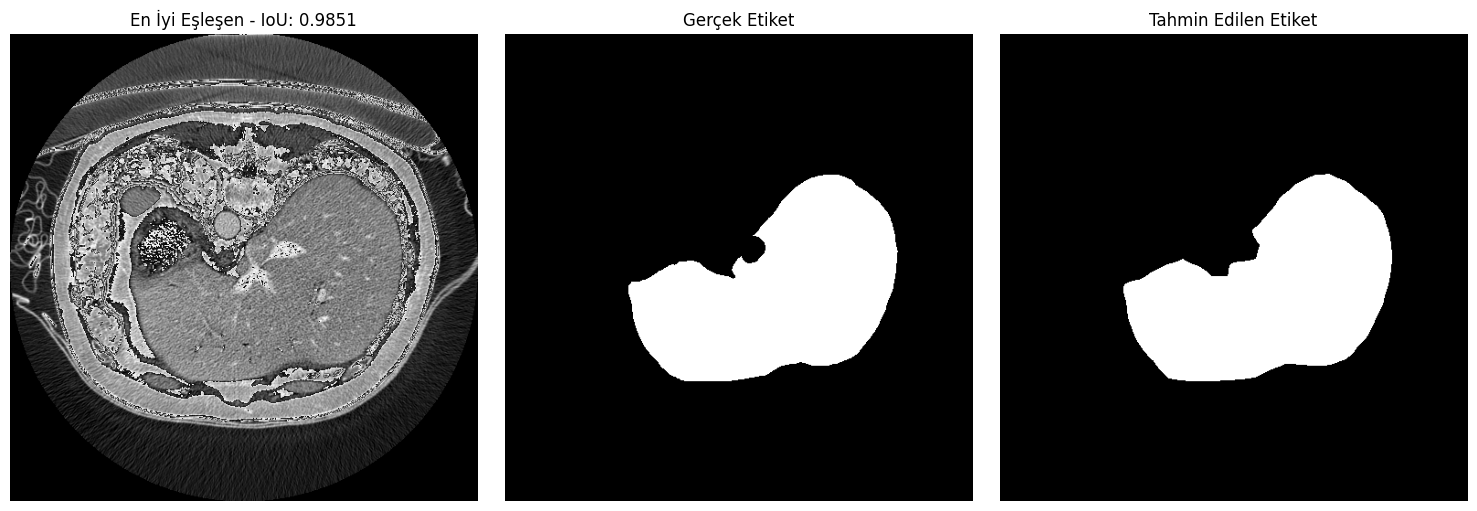

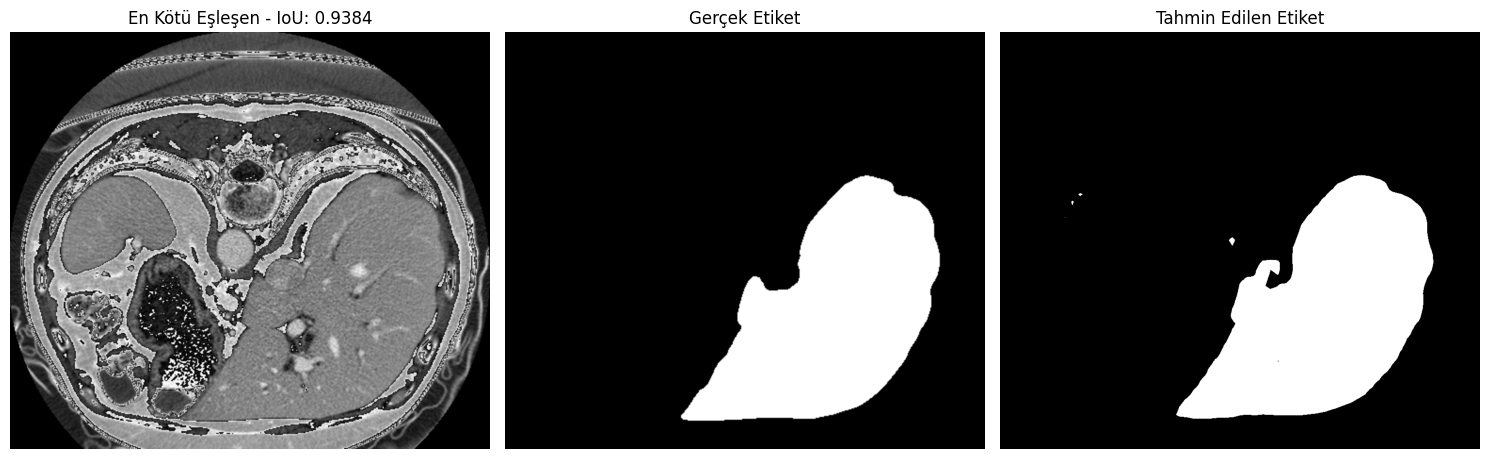

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

# IoU hesaplama fonksiyonu
def calculate_iou(pred, target, threshold=0.5):
    # İkili maske haline getir
    pred_binary = (pred > threshold).astype(float)
    target_binary = (target > threshold).astype(float)

    # Kesişim ve birleşim
    intersection = np.sum(pred_binary * target_binary)
    union = np.sum(pred_binary) + np.sum(target_binary) - intersection

    # IoU hesapla
    iou = intersection / (union + 1e-6)  # 1e-6 küçük bir değer ekleyerek bölme hatasını önler
    return iou

# Test fonksiyonu
def evaluate_model(model, test_dataset, num_samples=10):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    iou_scores = []
    best_match = None
    worst_match = None
    best_iou = -1
    worst_iou = float('inf')

    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            if i >= num_samples:
                break
            
            # Veriyi cihaza taşı ve FP16'ya dönüştür
            image = image.to(device).half()
            label = label.squeeze().numpy()  # Gerçek etiketi numpy formatına çevir
            
            # Modelden çıktı al
            output = model(image)['out']
            output = torch.sigmoid(output).squeeze().cpu().numpy()

            # IoU hesapla
            iou = calculate_iou(output, label)
            iou_scores.append(iou)

            # En iyi ve en kötü eşleşen görüntüleri bul
            if iou > best_iou:
                best_iou = iou
                best_match = (image.cpu().squeeze(), label, output)
            
            if iou < worst_iou:
                worst_iou = iou
                worst_match = (image.cpu().squeeze(), label, output)

    print(f"En iyi eşleşen IoU: {best_iou:.4f}")
    print(f"En kötü eşleşen IoU: {worst_iou:.4f}")

    # Görüntüleri göster
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(TF.to_pil_image(best_match[0]), cmap='gray')
    axes[0].set_title(f"En İyi Eşleşen - IoU: {best_iou:.4f}")
    axes[0].axis("off")

    axes[1].imshow(best_match[1], cmap='gray')
    axes[1].set_title("Gerçek Etiket")
    axes[1].axis("off")

    axes[2].imshow(best_match[2] > 0.5, cmap='gray')
    axes[2].set_title("Tahmin Edilen Etiket")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(TF.to_pil_image(worst_match[0]), cmap='gray')
    axes[0].set_title(f"En Kötü Eşleşen - IoU: {worst_iou:.4f}")
    axes[0].axis("off")

    axes[1].imshow(worst_match[1], cmap='gray')
    axes[1].set_title("Gerçek Etiket")
    axes[1].axis("off")

    axes[2].imshow(worst_match[2] > 0.5, cmap='gray')
    axes[2].set_title("Tahmin Edilen Etiket")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Test için SpineDataset oluştur
test_dataset = SpineDataset(image_dir, label_dir, transform=preprocess_image)

# Modeli yükle (FP16 formatı)
model.load_state_dict(torch.load("deeplabv3_model_fp16.pth", map_location=device))
model = model.to(device).half()  # Modeli FP16 formatına geçir
print("Model başarıyla yüklendi!")

# Test et ve en iyi/kötü eşleşen görüntüleri göster
evaluate_model(model, test_dataset, num_samples=10)